In [131]:
from qibo.noise import NoiseModel, DepolarizingError

In [132]:
import torch
import numpy as np
from qibo import Circuit, gates
import matplotlib.pyplot as plt

In [133]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # DEPOLARIZING NOISE TO INPUT STATE
    circuit.add(gates.DepolarizingChannel(0, 0.1))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [134]:
class Client:
    def __init__(self, num_samples, seed, vqc_class=QuantumModel, sigma=0, target_class0_ratio=None, n_shots=1):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.target_class0_ratio = target_class0_ratio
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        self.n_shots = n_shots  # Number of shots for gradient calculation
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_theta(self, new_theta):
        with torch.no_grad():
            self.model.theta.copy_(torch.tensor(new_theta, dtype=torch.float64))

    
    def get_theta(self):
        return self.model.theta.detach().numpy()


    # def compute_grad(self, x_input, theta, label, shift=np.pi/2):
    #     grad = parameter_shift_grad(x_input=x_input, theta=theta, label=label, shift=shift, n_shots=self.n_shots)
    #     return grad
            

    def local_train(self, batch_size, lr=0.1):

        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_theta()  # No more data

        training_data = self.labels[start:end]
        theta_history = []
        grads = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
        
        for epoch, label in enumerate(training_data):
            #print("LABEL USED:", label)
            x_input = label
            optimizer.zero_grad()
        
            # Estimate gradient via parameter-shift
            grad_estimate = parameter_shift_grad(x_input, self.model.theta.item(), label, n_shots=self.n_shots)
            grads.append(grad_estimate)
            
            # Manually assign gradient to parameter
            self.model.theta.grad = torch.tensor([grad_estimate], dtype=torch.float32)
        
            optimizer.step()
        
            # Track accuracy and current value
            #prediction = self.model(x_input)
            #correct = (prediction == label)
            #theta_history.append(np.round(self.model.theta.item(), 4))
            #print(f"Epoch {epoch:03d} | x={x_input} | Label={label} | Pred={prediction} | θ={self.model.theta.item():.4f} | Correct={correct}")
            theta = self.get_theta().copy()
            #print("Updated parameters to:",theta[0])
            local_weights_evolution_aux.append(theta[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_theta()

In [135]:
def create_clients_setup(num_clients=5, num_samples=100, sigma_range=(0.0, 0.0), seed=0, vqc_class=QuantumModel, 
                         target_class0_ratio=None, n_shots=1):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        target_class0_ratio=target_class0_ratio,
                        n_shots=n_shots)
        clients.append(client)

    return clients

In [136]:
def compute_Psuccess(client):
    Ps0 = client.model(0)(nshots=None).probabilities()[0]
    Ps1 = client.model(1)(nshots=None).probabilities()[1]

    Psuc = 0.5 * (Ps0 + Ps1)
    return Psuc

In [137]:
def repeat_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            for client in clients:
                client.local_train(client.num_samples, lr=lr)
                client_test = Client(None, None, vqc_class=QuantumModel_test)
                client_test.set_theta(client.get_theta())
                client_psuc = np.round(compute_Psuccess(client_test), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs) 

In [138]:
def compute_optimal_lr(all_Psucs, lr_values, num_seeds):
      
    data_per_lr = all_Psucs.T  # (40, 3)
    data_list = [data_per_lr[i, :] for i in range(data_per_lr.shape[0])]
    
    plt.figure(figsize=(12, 6))
    
    # use integer positions instead of actual LR values for spacing
    positions = np.arange(len(lr_values))
    
    plt.boxplot(data_list, positions=positions, widths=0.6, patch_artist=True)
    
    # make x-ticks readable
    plt.xticks(
        positions[::2],  # show every 2nd tick
        [f"{lr:.2f}" for lr in lr_values[::2]], 
        rotation=45,
    )
    
    plt.xlabel("Learning rate")
    plt.ylabel("Mean Psuc")
    plt.title(f"Performance across {num_seeds} seeds for different learning rates")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # optional: overlay mean line
    means = data_per_lr.mean(axis=1)
    plt.plot(positions, means, color="red", marker="o", linewidth=2, label="Mean across seeds")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # compute mean across seeds for each lr
    means = data_per_lr.mean(axis=1)
    
    # find best lr
    best_idx = np.argmax(means)
    best_lr = lr_values[best_idx]
    best_value = means[best_idx]
    
    print(f"Best learning rate: {best_lr:.2f} with mean Psuc = {best_value:.4f}")
 

    return np.round(best_lr, 2)

In [139]:
def visualize_label_dist(clients):
    # Collect label distributions from all clients
    distributions = [client.get_label_distribution() for client in clients]
    
    # Extract class names from the first client (assuming all clients have the same classes)
    classes = list(distributions[0].keys())
    n_clients = len(distributions)
    
    # Build a matrix of shape (n_clients, n_classes)
    matrix = np.array([[dist[c] for c in classes] for dist in distributions])

    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = np.zeros(n_clients)
    for i, c in enumerate(classes):
        values = matrix[:, i]
        ax.bar(range(n_clients), values, bottom=bottom, label=c)
        bottom += values
    
    ax.set_xticks(range(n_clients))
    ax.set_xticklabels([f"Client {i}" for i in range(n_clients)], rotation=45)
    ax.set_ylabel("Proportion")
    ax.set_title("Stacked Label Distribution per Client")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [140]:
# QFL functions

In [141]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [142]:
def run_federated_training_ECAI(clients, num_rounds, lr, local_batch_size=5):
    
    global_weights_evolution = []
    for rnd in range(num_rounds):
        #print(f"\n--- Round {rnd+1} ---")

        # for client in clients:
        #     for param in client.model.parameters():
        #         print("CLIENT PARAM:", param)
        
        local_weights = []

        for client in clients:
            weights = client.local_train(batch_size=local_batch_size, lr=lr)
            local_weights.append(weights)

        # for client in clients:
        #     for param in client.model.parameters():
        #         print(param)

        # Federated averaging
        global_weights = average_angles_modulo(local_weights)
        global_weights_evolution.append(global_weights)
        # print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_theta(global_weights)

    return global_weights_evolution

In [143]:
def repeat_ECAI_QFL_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            global_weights_evolution = run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None, vqc_class=QuantumModel_test)
            QFL_client.set_theta(global_weights_evolution[-1])
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

In [145]:
# ----------- Quantum circuit builder -----------
def build_circuit_test(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # # DEPOLARIZING NOISE TO INPUT STATE
    # circuit.add(gates.DepolarizingChannel(0, 0.5))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel_test(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit_test(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [144]:
optimal_client = Client(None, None, vqc_class=QuantumModel_test)
optimal_client.set_theta(np.pi/4)
optimal_Psuc = compute_Psuccess(optimal_client)
print(optimal_Psuc)

0.8535533905932735


# Setup 1 ---- 50 samples, 10 clients

In [16]:
num_clients = 10
num_samples = 50

## σ=0.0

In [17]:
sigma_range = (0.0, 0.0)

### Single client 1 shot

In [18]:
n_shots = 1

In [19]:
# SETUP PARAMETER

lr_values = [0.17]
seeds = np.arange(0, 100)

In [20]:
all_mean_Psucs_1s_s0_setup1, all_min_Psucs_1s_s0_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.17]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [21]:
n_shots = 10

In [22]:
# SETUP PARAMETER

lr_values = [0.14]
seeds = np.arange(0, 100)

In [23]:
all_mean_Psucs_10s_s0_setup1, all_min_Psucs_10s_s0_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 10
 - lr: [0.14]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [24]:
n_shots = 100

In [25]:
# SETUP PARAMETER

lr_values = [0.12]
seeds = np.arange(0, 100)

In [26]:
all_mean_Psucs_100s_s0_setup1, all_min_Psucs_100s_s0_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 100
 - lr: [0.12]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 2 rounds wit 25 local updates

In [27]:
# SETUP PARAMETER
num_rounds = 2
local_batch_size = 25

lr_values = [0.11]
seeds = np.arange(0, 100)

n_shots = 1

In [28]:
QFL_Psucs_s0_2_25_setup1 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 2
 - Local Batch: 25
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=0.5

In [29]:
sigma_range = (0.5, 0.5)

### Single client 1 shot

In [30]:
n_shots = 1

In [31]:
# SETUP PARAMETER

lr_values = [0.19]
seeds = np.arange(0, 100)

In [32]:
all_mean_Psucs_1s_s05_setup1, all_min_Psucs_1s_s05_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.19]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [33]:
n_shots = 10

In [34]:
# SETUP PARAMETER

lr_values = [0.13]
seeds = np.arange(0, 100)

In [35]:
all_mean_Psucs_10s_s05_setup1, all_min_Psucs_10s_s05_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 10
 - lr: [0.13]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [36]:
n_shots = 100

In [37]:
# SETUP PARAMETER

lr_values = [0.11]
seeds = np.arange(0, 100)

In [38]:
all_mean_Psucs_100s_s05_setup1, all_min_Psucs_100s_s05_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 100
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 2 rounds wit 25 local updates

In [39]:
# SETUP PARAMETER
num_rounds = 2
local_batch_size = 25

lr_values = [0.10]
seeds = np.arange(0, 100)

n_shots = 1

In [40]:
QFL_Psucs_s05_2_25_setup1 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 2
 - Local Batch: 25
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=1.0

In [41]:
sigma_range = (1.0, 1.0)

### Single client 1 shot

In [42]:
n_shots = 1

In [43]:
# SETUP PARAMETER

lr_values = [0.16]
seeds = np.arange(0, 100)

In [44]:
all_mean_Psucs_1s_s1_setup1, all_min_Psucs_1s_s1_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.16]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [45]:
n_shots = 10

In [46]:
# SETUP PARAMETER

lr_values = [0.11]
seeds = np.arange(0, 100)

In [47]:
all_mean_Psucs_10s_s1_setup1, all_min_Psucs_10s_s1_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 10
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [48]:
n_shots = 100

In [49]:
# SETUP PARAMETER

lr_values = [0.12]
seeds = np.arange(0, 100)

In [50]:
all_mean_Psucs_100s_s1_setup1, all_min_Psucs_100s_s1_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 100
 - lr: [0.12]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 2 rounds wit 25 local updates

In [51]:
# SETUP PARAMETER
num_rounds = 2
local_batch_size = 25

lr_values = [0.11]
seeds = np.arange(0, 100)

n_shots = 1

In [52]:
QFL_Psucs_s1_2_25_setup1 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 2
 - Local Batch: 25
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=4.0

In [53]:
sigma_range = (4.0, 4.0)

### Single client 1 shot

In [54]:
n_shots = 1

In [55]:
# SETUP PARAMETER

lr_values = [0.10]
seeds = np.arange(0, 100)

In [56]:
all_mean_Psucs_1s_s4_setup1, all_min_Psucs_1s_s4_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [57]:
n_shots = 10

In [58]:
# SETUP PARAMETER

lr_values = [0.13]
seeds = np.arange(0, 100)

In [59]:
all_mean_Psucs_10s_s4_setup1, all_min_Psucs_10s_s4_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 10
 - lr: [0.13]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [60]:
n_shots = 100

In [61]:
# SETUP PARAMETER

lr_values = [0.10]
seeds = np.arange(0, 100)

In [62]:
all_mean_Psucs_100s_s4_setup1, all_min_Psucs_100s_s4_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 100
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 2 rounds wit 25 local updates

In [63]:
# SETUP PARAMETER
num_rounds = 2
local_batch_size = 25

lr_values = [0.15]
seeds = np.arange(0, 100)

n_shots = 1

In [64]:
QFL_Psucs_s4_2_25_setup1 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 2
 - Local Batch: 25
 - lr: [0.15]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


# Setup 2 ---- 25 samples, 10 clients

In [76]:
num_clients = 10
num_samples = 25

## σ=0.0

In [77]:
sigma_range = (0.0, 0.0)

### Single client 1 shot

In [78]:
n_shots = 1

In [79]:
# SETUP PARAMETER

lr_values = [0.27]
seeds = np.arange(0, 100)

In [80]:
all_mean_Psucs_1s_s0_setup2, all_min_Psucs_1s_s0_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.27]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [81]:
n_shots = 10

In [82]:
# SETUP PARAMETER

lr_values = [0.21]
seeds = np.arange(0, 100)

In [83]:
all_mean_Psucs_10s_s0_setup2, all_min_Psucs_10s_s0_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 10
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [84]:
n_shots = 100

In [85]:
# SETUP PARAMETER

lr_values = [0.18]
seeds = np.arange(0, 100)

In [86]:
all_mean_Psucs_100s_s0_setup2, all_min_Psucs_100s_s0_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 100
 - lr: [0.18]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 5 rounds wit 5 local updates

In [87]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.19]
seeds = np.arange(0, 100)

n_shots = 1

In [88]:
QFL_Psucs_s0_setup2 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.19]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=0.5

In [89]:
sigma_range = (0.5, 0.5)

### Single client 1 shot

In [90]:
n_shots = 1

In [91]:
# SETUP PARAMETER

lr_values = [0.26]
seeds = np.arange(0, 100)

In [92]:
all_mean_Psucs_1s_s05_setup2, all_min_Psucs_1s_s05_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.26]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [93]:
n_shots = 10

In [94]:
# SETUP PARAMETER

lr_values = [0.22]
seeds = np.arange(0, 100)

In [95]:
all_mean_Psucs_10s_s05_setup2, all_min_Psucs_10s_s05_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 10
 - lr: [0.22]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [96]:
n_shots = 100

In [97]:
# SETUP PARAMETER

lr_values = [0.21]
seeds = np.arange(0, 100)

In [98]:
all_mean_Psucs_100s_s05_setup2, all_min_Psucs_100s_s05_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 100
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 5 rounds wit 5 local updates

In [99]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.20]
seeds = np.arange(0, 100)

n_shots = 1

In [100]:
QFL_Psucs_s05_setup2 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.2]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=1.0

In [101]:
sigma_range = (1.0, 1.0)

### Single client 1 shot

In [102]:
n_shots = 1

In [103]:
# SETUP PARAMETER

lr_values = [0.17]
seeds = np.arange(0, 100)

In [104]:
all_mean_Psucs_1s_s1_setup2, all_min_Psucs_1s_s1_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.17]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [105]:
n_shots = 10

In [106]:
# SETUP PARAMETER

lr_values = [0.20]
seeds = np.arange(0, 100)

In [107]:
all_mean_Psucs_10s_s1_setup2, all_min_Psucs_10s_s1_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 10
 - lr: [0.2]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [108]:
n_shots = 100

In [109]:
# SETUP PARAMETER

lr_values = [0.21]
seeds = np.arange(0, 100)

In [110]:
all_mean_Psucs_100s_s1_setup2, all_min_Psucs_100s_s1_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 100
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 5 rounds wit 5 local updates

In [111]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.18]
seeds = np.arange(0, 100)

n_shots = 1

In [112]:
QFL_Psucs_s1_setup2 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.18]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=4.0

In [113]:
sigma_range = (4.0, 4.0)

### Single client 1 shot

In [114]:
n_shots = 1

In [115]:
# SETUP PARAMETER

lr_values = [0.14]
seeds = np.arange(0, 100)

In [116]:
all_mean_Psucs_1s_s4_setup2, all_min_Psucs_1s_s4_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.14]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [117]:
n_shots = 10

In [118]:
# SETUP PARAMETER

lr_values = [0.19]
seeds = np.arange(0, 100)

In [119]:
all_mean_Psucs_10s_s4_setup2, all_min_Psucs_10s_s4_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 10
 - lr: [0.19]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [120]:
n_shots = 100

In [121]:
# SETUP PARAMETER

lr_values = [0.13]
seeds = np.arange(0, 100)

In [122]:
all_mean_Psucs_100s_s4_setup2, all_min_Psucs_100s_s4_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 100
 - lr: [0.13]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 5 rounds wit 5 local updates

In [123]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.23]
seeds = np.arange(0, 100)

n_shots = 1

In [124]:
QFL_Psucs_s4_setup2 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.23]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


# Setup 3 ---- 5 samples, 10 clients

In [146]:
num_clients = 10
num_samples = 5

## σ=0.0

In [147]:
sigma_range = (0.0, 0.0)

### Single client 1 shot

In [148]:
n_shots = 1

In [149]:
# SETUP PARAMETER

lr_values = [0.61]
seeds = np.arange(0, 100)

In [150]:
all_mean_Psucs_1s_s0_setup3, all_min_Psucs_1s_s0_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.61]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [117]:
n_shots = 10

In [151]:
# SETUP PARAMETER

lr_values = [0.71]
seeds = np.arange(0, 100)

In [152]:
all_mean_Psucs_10s_s0_setup3, all_min_Psucs_10s_s0_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.71]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [153]:
n_shots = 100

In [154]:
# SETUP PARAMETER

lr_values = [0.69]
seeds = np.arange(0, 100)

In [155]:
all_mean_Psucs_100s_s0_setup3, all_min_Psucs_100s_s0_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 100
 - lr: [0.69]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [156]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.57]
seeds = np.arange(0, 100)

n_shots = 1

In [157]:
QFL_Psucs_s0_setup3 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.57]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=0.5

In [158]:
sigma_range = (0.5, 0.5)

### Single client 1 shot

In [159]:
n_shots = 1

In [160]:
# SETUP PARAMETER

lr_values = [0.70]
seeds = np.arange(0, 100)

In [161]:
all_mean_Psucs_1s_s05_setup3, all_min_Psucs_1s_s05_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.7]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [162]:
n_shots = 10

In [163]:
# SETUP PARAMETER

lr_values = [0.72]
seeds = np.arange(0, 100)

In [164]:
all_mean_Psucs_10s_s05_setup3, all_min_Psucs_10s_s05_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 10
 - lr: [0.72]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [165]:
n_shots = 100

In [166]:
# SETUP PARAMETER

lr_values = [0.71]
seeds = np.arange(0, 100)

In [167]:
all_mean_Psucs_100s_s05_setup3, all_min_Psucs_100s_s05_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 100
 - lr: [0.71]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [168]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.59]
seeds = np.arange(0, 100)

n_shots = 1

In [169]:
QFL_Psucs_s05_setup3 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.59]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=1.0

In [170]:
sigma_range = (1.0, 1.0)

### Single client 1 shot

In [171]:
n_shots = 1

In [172]:
# SETUP PARAMETER

lr_values = [0.65]
seeds = np.arange(0, 100)

In [173]:
all_mean_Psucs_1s_s1_setup3, all_min_Psucs_1s_s1_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.65]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [174]:
n_shots = 10

In [175]:
# SETUP PARAMETER

lr_values = [0.68]
seeds = np.arange(0, 100)

In [176]:
all_mean_Psucs_10s_s1_setup3, all_min_Psucs_10s_s1_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 10
 - lr: [0.68]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [177]:
n_shots = 100

In [178]:
# SETUP PARAMETER

lr_values = [0.60]
seeds = np.arange(0, 100)

In [179]:
all_mean_Psucs_100s_s1_setup3, all_min_Psucs_100s_s1_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 100
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [180]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.61]
seeds = np.arange(0, 100)

n_shots = 1

In [181]:
QFL_Psucs_s1_setup3 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.61]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=4.0

In [182]:
sigma_range = (4.0, 4.0)

### Single client 1 shot

In [183]:
n_shots = 1

In [184]:
# SETUP PARAMETER

lr_values = [0.66]
seeds = np.arange(0, 100)

In [185]:
all_mean_Psucs_1s_s4_setup3, all_min_Psucs_1s_s4_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.66]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [186]:
n_shots = 10

In [187]:
# SETUP PARAMETER

lr_values = [0.58]
seeds = np.arange(0, 100)

In [188]:
all_mean_Psucs_10s_s4_setup3, all_min_Psucs_10s_s4_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 10
 - lr: [0.58]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [189]:
n_shots = 100

In [190]:
# SETUP PARAMETER

lr_values = [0.61]
seeds = np.arange(0, 100)

In [191]:
all_mean_Psucs_100s_s4_setup3, all_min_Psucs_100s_s4_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 100
 - lr: [0.61]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round wit 5 local updates

In [192]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.88]
seeds = np.arange(0, 100)

n_shots = 1

In [193]:
QFL_Psucs_s4_setup3 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.88]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


# Setup 4 ---- 5 samples, 25 clients

In [194]:
num_clients = 25
num_samples = 5

## σ=0.0

In [195]:
sigma_range = (0.0, 0.0)

### Single client 1 shot

In [196]:
n_shots = 1

In [197]:
# SETUP PARAMETER

lr_values = [0.70]
seeds = np.arange(0, 100)

In [198]:
all_mean_Psucs_1s_s0_setup4, all_min_Psucs_1s_s0_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.7]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [200]:
n_shots = 10

In [201]:
# SETUP PARAMETER

lr_values = [0.70]
seeds = np.arange(0, 100)

In [202]:
all_mean_Psucs_10s_s0_setup4, all_min_Psucs_10s_s0_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 10
 - lr: [0.7]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [203]:
n_shots = 100

In [204]:
# SETUP PARAMETER

lr_values = [0.69]
seeds = np.arange(0, 100)

In [205]:
all_mean_Psucs_100s_s0_setup4, all_min_Psucs_100s_s0_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 100
 - lr: [0.69]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [206]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.61]
seeds = np.arange(0, 100)

n_shots = 1

In [207]:
QFL_Psucs_s0_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.61]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=0.5

In [208]:
sigma_range = (0.5, 0.5)

### Single client 1 shot

In [209]:
n_shots = 1

In [210]:
# SETUP PARAMETER

lr_values = [0.63]
seeds = np.arange(0, 100)

In [211]:
all_mean_Psucs_1s_s05_setup4, all_min_Psucs_1s_s05_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.63]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [212]:
n_shots = 10

In [213]:
# SETUP PARAMETER

lr_values = [0.67]
seeds = np.arange(0, 100)

In [214]:
all_mean_Psucs_10s_s05_setup4, all_min_Psucs_10s_s05_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 10
 - lr: [0.67]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [215]:
n_shots = 100

In [216]:
# SETUP PARAMETER

lr_values = [0.64]
seeds = np.arange(0, 100)

In [217]:
all_mean_Psucs_100s_s05_setup4, all_min_Psucs_100s_s05_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 100
 - lr: [0.64]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [218]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.62]
seeds = np.arange(0, 100)

n_shots = 1

In [219]:
QFL_Psucs_s05_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.62]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=1.0

In [220]:
sigma_range = (1.0, 1.0)

### Single client 1 shot

In [221]:
n_shots = 1

In [222]:
# SETUP PARAMETER

lr_values = [0.62]
seeds = np.arange(0, 100)

In [223]:
all_mean_Psucs_1s_s1_setup4, all_min_Psucs_1s_s1_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.62]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [224]:
n_shots = 10

In [225]:
# SETUP PARAMETER

lr_values = [0.65]
seeds = np.arange(0, 100)

In [226]:
all_mean_Psucs_10s_s1_setup4, all_min_Psucs_10s_s1_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 10
 - lr: [0.65]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [230]:
n_shots = 100

In [231]:
# SETUP PARAMETER

lr_values = [0.59]
seeds = np.arange(0, 100)

In [232]:
all_mean_Psucs_100s_s1_setup4, all_min_Psucs_100s_s1_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 100
 - lr: [0.59]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [233]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.57]
seeds = np.arange(0, 100)

n_shots = 1

In [234]:
QFL_Psucs_s1_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.57]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=4.0

In [235]:
sigma_range = (4.0, 4.0)

### Single client 1 shot

In [236]:
n_shots = 1

In [237]:
# SETUP PARAMETER

lr_values = [0.69]
seeds = np.arange(0, 100)

In [238]:
all_mean_Psucs_1s_s4_setup4, all_min_Psucs_1s_s4_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.69]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [239]:
n_shots = 10

In [240]:
# SETUP PARAMETER

lr_values = [0.64]
seeds = np.arange(0, 100)

In [241]:
all_mean_Psucs_10s_s4_setup4, all_min_Psucs_10s_s4_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 10
 - lr: [0.64]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [242]:
n_shots = 100

In [243]:
# SETUP PARAMETER

lr_values = [0.59]
seeds = np.arange(0, 100)

In [244]:
all_mean_Psucs_100s_s4_setup4, all_min_Psucs_100s_s4_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 100
 - lr: [0.59]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round wit 5 local updates

In [245]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.68]
seeds = np.arange(0, 100)

n_shots = 1

In [246]:
QFL_Psucs_s4_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.68]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


# Setup 5 ---- 5 samples, 50 clients

In [251]:
num_clients = 50
num_samples = 5

## σ=0.0

In [252]:
sigma_range = (0.0, 0.0)

### Single client 1 shot

In [253]:
n_shots = 1

In [254]:
# SETUP PARAMETER

lr_values = [0.62]
seeds = np.arange(0, 100)

In [255]:
all_mean_Psucs_1s_s0_setup5, all_min_Psucs_1s_s0_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.62]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [256]:
n_shots = 10

In [257]:
# SETUP PARAMETER

lr_values = [0.64]
seeds = np.arange(0, 100)

In [258]:
all_mean_Psucs_10s_s0_setup5, all_min_Psucs_10s_s0_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 10
 - lr: [0.64]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [259]:
n_shots = 100

In [260]:
# SETUP PARAMETER

lr_values = [0.66]
seeds = np.arange(0, 100)

In [261]:
all_mean_Psucs_100s_s0_setup5, all_min_Psucs_100s_s0_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 100
 - lr: [0.66]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [262]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.60]
seeds = np.arange(0, 100)

n_shots = 1

In [263]:
QFL_Psucs_s0_setup5 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=0.5

In [264]:
sigma_range = (0.5, 0.5)

### Single client 1 shot

In [265]:
n_shots = 1

In [266]:
# SETUP PARAMETER

lr_values = [0.60]
seeds = np.arange(0, 100)

In [267]:
all_mean_Psucs_1s_s05_setup5, all_min_Psucs_1s_s05_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [268]:
n_shots = 10

In [269]:
# SETUP PARAMETER

lr_values = [0.64]
seeds = np.arange(0, 100)

In [270]:
all_mean_Psucs_10s_s05_setup5, all_min_Psucs_10s_s05_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 10
 - lr: [0.64]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [271]:
n_shots = 100

In [272]:
# SETUP PARAMETER

lr_values = [0.60]
seeds = np.arange(0, 100)

In [273]:
all_mean_Psucs_100s_s05_setup5, all_min_Psucs_100s_s05_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 100
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [274]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.60]
seeds = np.arange(0, 100)

n_shots = 1

In [275]:
QFL_Psucs_s05_setup5 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=1.0

In [276]:
sigma_range = (1.0, 1.0)

### Single client 1 shot

In [277]:
n_shots = 1

In [278]:
# SETUP PARAMETER

lr_values = [0.60]
seeds = np.arange(0, 100)

In [279]:
all_mean_Psucs_1s_s1_setup5, all_min_Psucs_1s_s1_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [280]:
n_shots = 10

In [281]:
# SETUP PARAMETER

lr_values = [0.59]
seeds = np.arange(0, 100)

In [282]:
all_mean_Psucs_10s_s1_setup5, all_min_Psucs_10s_s1_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 10
 - lr: [0.59]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [283]:
n_shots = 100

In [284]:
# SETUP PARAMETER

lr_values = [0.56]
seeds = np.arange(0, 100)

In [285]:
all_mean_Psucs_100s_s1_setup5, all_min_Psucs_100s_s1_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 100
 - lr: [0.56]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round with 5 local updates

In [286]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.59]
seeds = np.arange(0, 100)

n_shots = 1

In [287]:
QFL_Psucs_s1_setup5 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.59]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


## σ=4.0

In [288]:
sigma_range = (4.0, 4.0)

### Single client 1 shot

In [289]:
n_shots = 1

In [290]:
# SETUP PARAMETER

lr_values = [0.59]
seeds = np.arange(0, 100)

In [291]:
all_mean_Psucs_1s_s4_setup5, all_min_Psucs_1s_s4_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.59]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡10 shots!

In [292]:
n_shots = 10

In [293]:
# SETUP PARAMETER

lr_values = [0.58]
seeds = np.arange(0, 100)

In [294]:
all_mean_Psucs_10s_s4_setup5, all_min_Psucs_10s_s4_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 10
 - lr: [0.58]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Single client ¡100 shots!

In [295]:
n_shots = 100

In [296]:
# SETUP PARAMETER

lr_values = [0.57]
seeds = np.arange(0, 100)

In [297]:
all_mean_Psucs_100s_s4_setup5, all_min_Psucs_100s_s4_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 100
 - lr: [0.57]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL - 1 round wit 5 local updates

In [298]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.62]
seeds = np.arange(0, 100)

n_shots = 1

In [299]:
QFL_Psucs_s4_setup5 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.62]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


# Comparisons

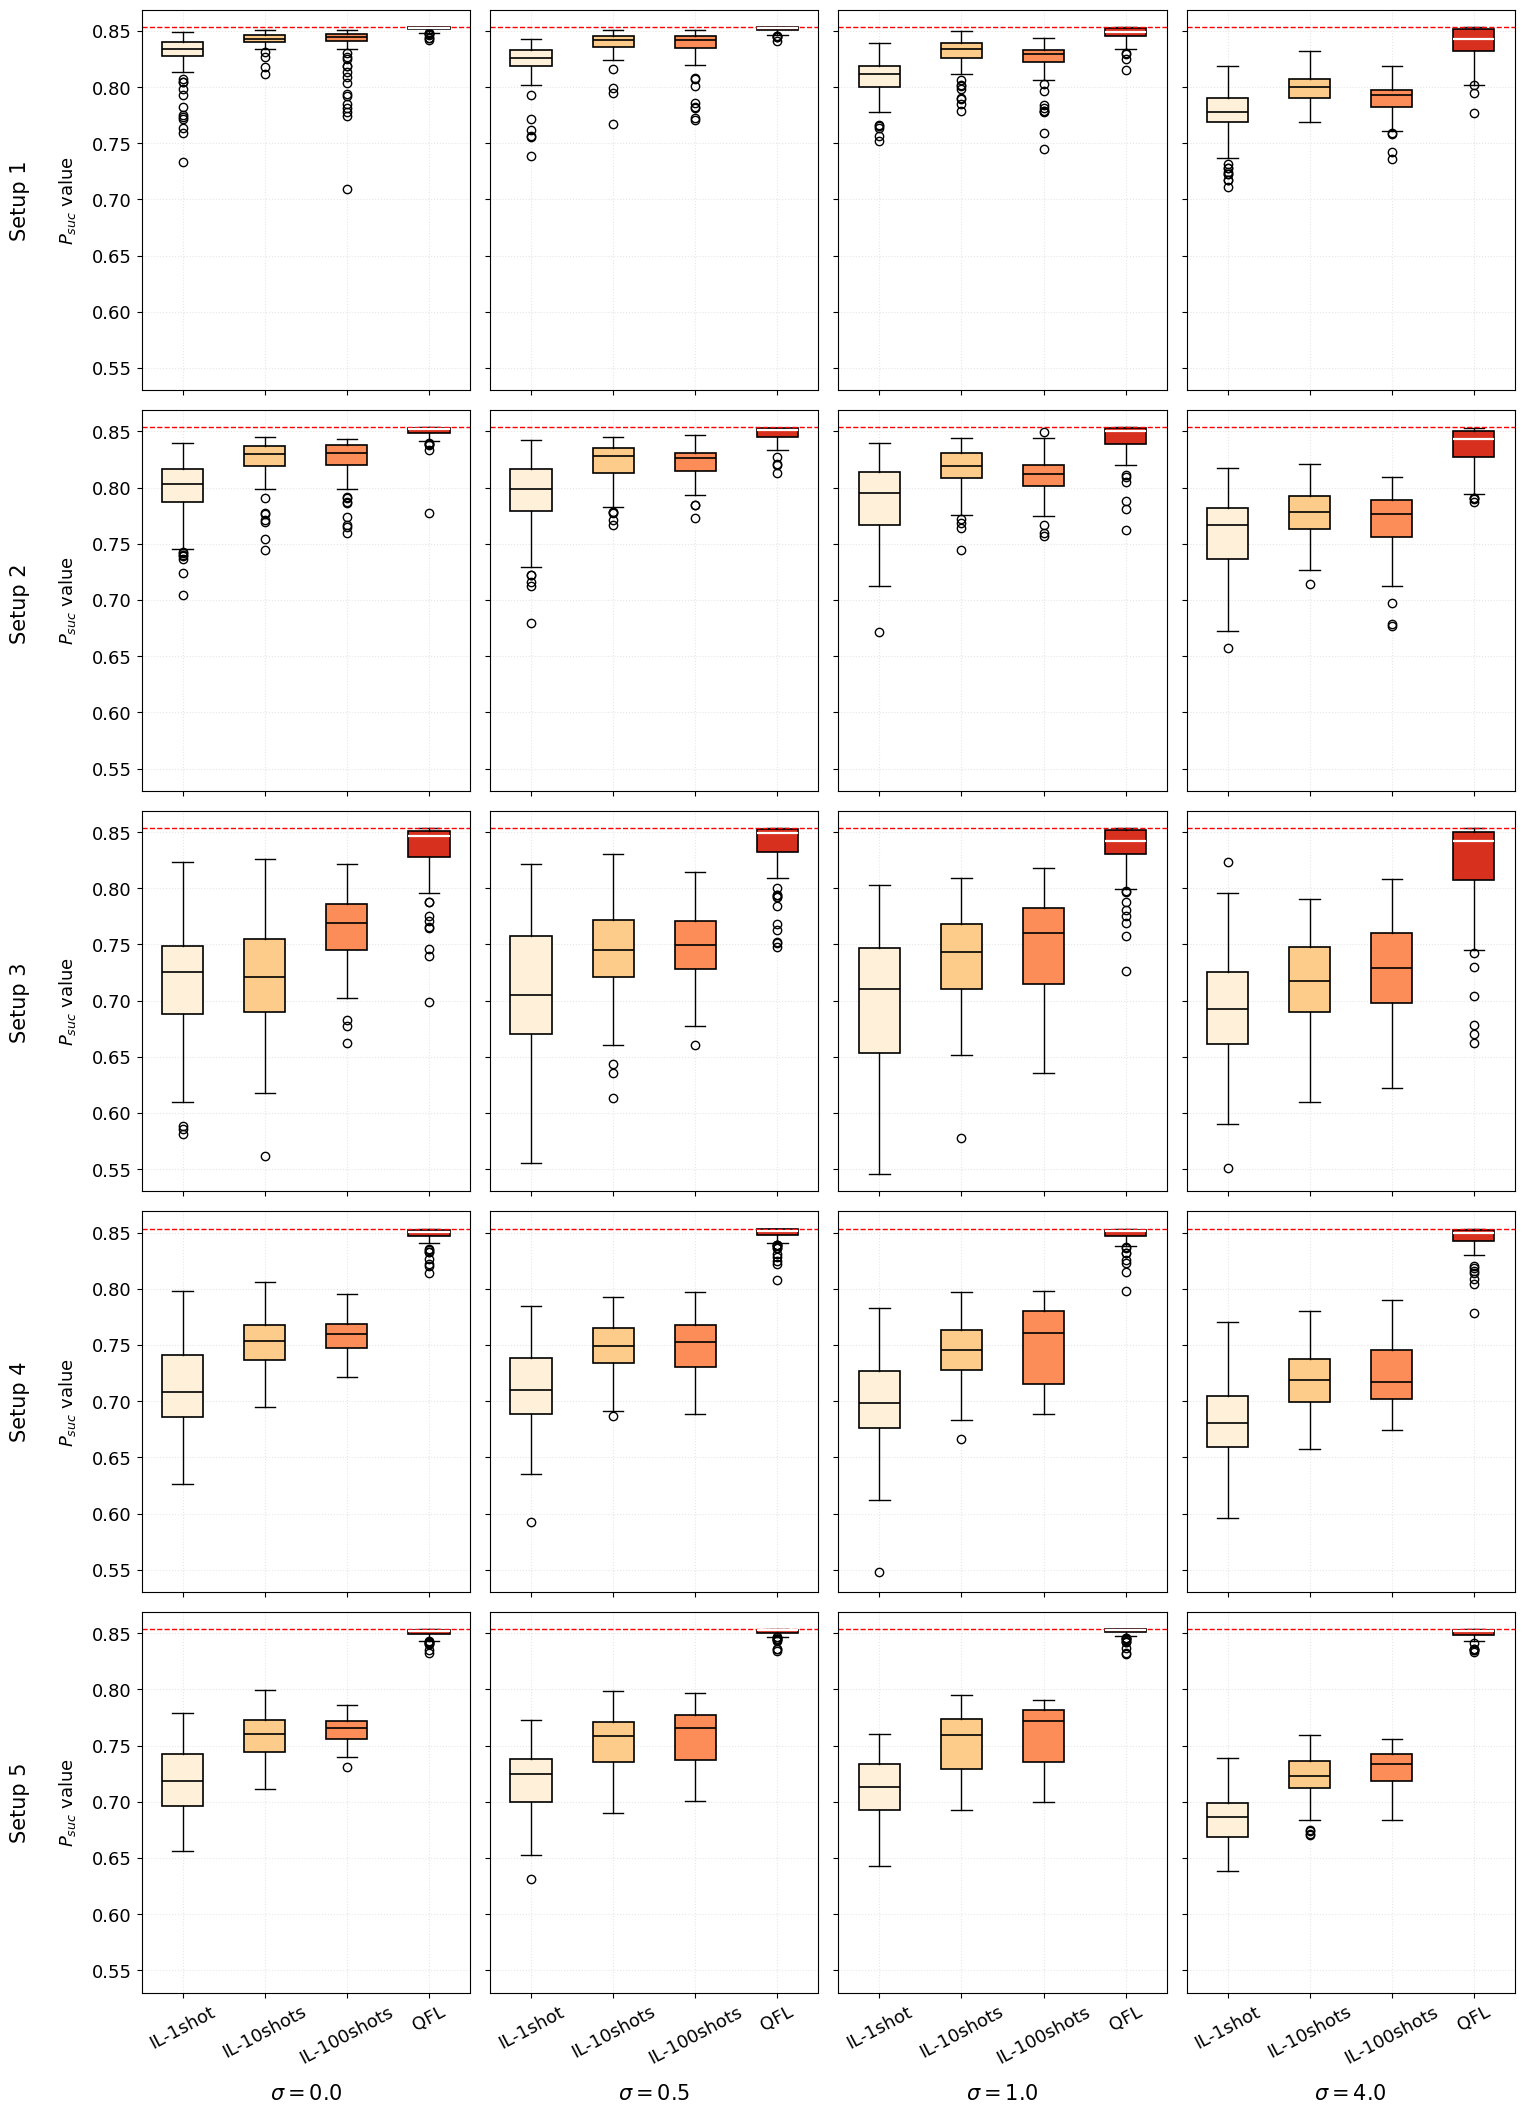

In [308]:
# --- Replace these with your actual data ---
data_sigma_1 = [
    (all_mean_Psucs_1s_s0_setup1, all_mean_Psucs_10s_s0_setup1, all_mean_Psucs_100s_s0_setup1, QFL_Psucs_s0_2_25_setup1),
    (all_mean_Psucs_1s_s05_setup1, all_mean_Psucs_10s_s05_setup1, all_mean_Psucs_100s_s05_setup1, QFL_Psucs_s05_2_25_setup1),
    (all_mean_Psucs_1s_s1_setup1, all_mean_Psucs_10s_s1_setup1, all_mean_Psucs_100s_s1_setup1, QFL_Psucs_s1_2_25_setup1),
    (all_mean_Psucs_1s_s4_setup1, all_mean_Psucs_10s_s4_setup1, all_mean_Psucs_100s_s4_setup1, QFL_Psucs_s4_2_25_setup1)
]
data_sigma_2 = [
    (all_mean_Psucs_1s_s0_setup2, all_mean_Psucs_10s_s0_setup2, all_mean_Psucs_100s_s0_setup2, QFL_Psucs_s0_setup2),
    (all_mean_Psucs_1s_s05_setup2, all_mean_Psucs_10s_s05_setup2, all_mean_Psucs_100s_s05_setup2, QFL_Psucs_s05_setup2),
    (all_mean_Psucs_1s_s1_setup2, all_mean_Psucs_10s_s1_setup2, all_mean_Psucs_100s_s1_setup2, QFL_Psucs_s1_setup2),
    (all_mean_Psucs_1s_s4_setup2, all_mean_Psucs_10s_s4_setup2, all_mean_Psucs_100s_s4_setup2, QFL_Psucs_s4_setup2)
]
data_sigma_3 = [
    (all_mean_Psucs_1s_s0_setup3, all_mean_Psucs_10s_s0_setup3, all_mean_Psucs_100s_s0_setup3, QFL_Psucs_s0_setup3),
    (all_mean_Psucs_1s_s05_setup3, all_mean_Psucs_10s_s05_setup3, all_mean_Psucs_100s_s05_setup3, QFL_Psucs_s05_setup3),
    (all_mean_Psucs_1s_s1_setup3, all_mean_Psucs_10s_s1_setup3, all_mean_Psucs_100s_s1_setup3, QFL_Psucs_s1_setup3),
    (all_mean_Psucs_1s_s4_setup3, all_mean_Psucs_10s_s4_setup3, all_mean_Psucs_100s_s4_setup3, QFL_Psucs_s4_setup3)
]
data_sigma_4 = [
    (all_mean_Psucs_1s_s0_setup4, all_mean_Psucs_10s_s0_setup4, all_mean_Psucs_100s_s0_setup4, QFL_Psucs_s0_setup4),
    (all_mean_Psucs_1s_s05_setup4, all_mean_Psucs_10s_s05_setup4, all_mean_Psucs_100s_s05_setup4, QFL_Psucs_s05_setup4),
    (all_mean_Psucs_1s_s1_setup4, all_mean_Psucs_10s_s1_setup4, all_mean_Psucs_100s_s1_setup4, QFL_Psucs_s1_setup4),
    (all_mean_Psucs_1s_s4_setup4, all_mean_Psucs_10s_s4_setup4, all_mean_Psucs_100s_s4_setup4, QFL_Psucs_s4_setup4)
]
data_sigma_5 = [
    (all_mean_Psucs_1s_s0_setup5, all_mean_Psucs_10s_s0_setup5, all_mean_Psucs_100s_s0_setup5, QFL_Psucs_s0_setup5),
    (all_mean_Psucs_1s_s05_setup5, all_mean_Psucs_10s_s05_setup5, all_mean_Psucs_100s_s05_setup5, QFL_Psucs_s05_setup5),
    (all_mean_Psucs_1s_s1_setup5, all_mean_Psucs_10s_s1_setup5, all_mean_Psucs_100s_s1_setup5, QFL_Psucs_s1_setup5),
    (all_mean_Psucs_1s_s4_setup5, all_mean_Psucs_10s_s4_setup5, all_mean_Psucs_100s_s4_setup5, QFL_Psucs_s4_setup5)
]

paradigm_labels = ["IL-1shot", "IL-10shots", "IL-100shots", "QFL"]
sigma_labels = [r"$\sigma=0.0$", r"$\sigma=0.5$", r"$\sigma=1.0$", r"$\sigma=4.0$"]
setup_labels = ["Setup 1", "Setup 2", "Setup 3", "Setup 4", "Setup 5"]

color_SC_1   = "#fef0d9"   # IL-1shot
color_SC_10  = "#fdcc8a"   # IL-10shots
color_SC_100 = "#fc8d59"   # IL-100shots
color_QFL    = "#d7301f"   # QFL

box_colors = [color_SC_1, color_SC_10, color_SC_100, color_QFL]

fig, axes = plt.subplots(5, 4, figsize=(16, 21), sharey=True)
plt.subplots_adjust(left=0.09)

for row, data_sigma in enumerate([data_sigma_1, data_sigma_2, data_sigma_3, data_sigma_4, data_sigma_5]):
    for col, (data_1s, data_10s, data_100s, data_qfl) in enumerate(data_sigma):
        ax = axes[row, col]
        box_data = [
            data_1s.flatten(), data_10s.flatten(),
            data_100s.flatten(), data_qfl.flatten()
        ]
        positions = range(1, 5)
        bp = ax.boxplot(
            box_data,
            positions=positions,
            widths=0.5,
            patch_artist=True,
            boxprops=dict(color='black', linewidth=1.2),
            medianprops=dict(color='black', linewidth=1.2)
        )
        
        # ---- APPLY FILL COLORS ----
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
        
        # ---- MAKE QFL MEDIAN WHITE ----
        bp['medians'][3].set_color('white')
        bp['medians'][3].set_linewidth(1.6)
        ax.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
        ax.grid(True, linestyle=':', alpha=0.3)

        ax.set_xticks(positions)
        if row < 4:
            ax.set_xticklabels([""] * len(paradigm_labels))
        else:
            ax.set_xticklabels(paradigm_labels, rotation=28, fontsize=13)

        if col == 0:
            ax.set_ylabel("$P_{suc}$ value", fontsize=13, labelpad=10)
        ax.set_title("")

# Sigma labels below each column of last row, further away
for col, sigma_label in enumerate(sigma_labels):
    axes[-1, col].set_xlabel(sigma_label, fontsize=15)
    axes[-1, col].xaxis.set_label_coords(0.5, -0.24)  # Move label down

row_label_positions = [0.902, 0.71, 0.52, 0.33, 0.139]
for i, setup_label in enumerate(setup_labels):
    fig.text(-0.02, row_label_positions[i], setup_label, va='center', ha='left', fontsize=15, rotation=90)

for axrow in axes:
    for ax in axrow:
        ax.tick_params(axis='y', labelsize=13)

plt.tight_layout(rect=[0, 0, 0.93, 1])
plt.savefig("all_plots_noise01.png", dpi=600, bbox_inches="tight")
plt.show()